# Peforming Physics Simulation on Remote Application Server

### Motivation
In the fluid modeling industry (oil and gas, water resources), physics simulations are carried out to understand the flow of fluids porous media (rocks in the subsurface) via 3-D numerical simulations. The simulations are important for optimal planning and production of these resources. 

A third-party tool is used to perform the detailed simulations. First, a user creates a set of input files that contain instructions of the type of flow to model , e.g., number of phases (oil, gas, water), duration, production rates, etc. These files have a specific format that varies by vendor. Second, the user calls the 3rd-party tool with the input files to perform the flow calculations. After the computations, a set of output files are created and can be processed further depending on the use case. 

To run these workflows, a user must have access to the 3rd-party tool and they are often expensive. Additionally, the input files use specific keywords and syntax and a user must understand these keywords, in addition to the type of simulation to perform. 

Over the last few years, I have been developing an integrated application that performs the above tasks (in addition to many others tasks). The application automates the creation of the required input files, the interaction with the 3rd-party tool, and post-processing of the results. In most cases, these tasks have been abstracted and a user perform the required computations remotely by making a HTTP request to the application servers.

The application has been tested with specific benchmark models and one of models is described in this test. 


### Introduction
This notebook describes the application of a scientific application for performing physics simulations on remote server with application in the oil and gas industry. We are using a simple benchmark reservoir simulation model with dimensions (100x1x1). This notebook does not describe the details of the physics simulation. The interested reader is referred to this <a href="http://onwunalu.com/petroleum/tutorials/evaluate-waterflood/evaluating-waterflood-performance-reservoir-simulation-part-1/">article</a> series which demonstrates results of simulation in a simple cross-sectional model.


However, we note that tests shown below are performed on a single machine, i.e., the HTTP request application (this notebook) and servers are on the same machine.

### Typical workflow
The public interface of the application consists of a python server (Django) that receives HTTP requests. The Django server then forwards the calls to the application server (not written in python) that is not accessible from a public API. 


The steps for a typical request are described as follows:

* Django server receives a request at a particular API endpoint. The HTTP post data includes of a **project_id** and other related data (physics data) for the specific simulation run. Django then makes a request to the application server.

* The application server receives the data and creates all the necessary files required to perform the simulation. 
    * The application server automatically generates several input files required by the third-party application that performs the physics simulation calculations.
    
    * The application server calls the 3rd party application to perform the simulation. It is also possible to receive requests for multiple simulations and these are performed in parallel (using multiple threads). The application server monitors each simulation job until completion.
        
    * After the simulation(s), the application server processes the output files for each simulation and encodes them using JSON notation. 
    * The application server returns the JSON encoded results to Django server. This marks the end of tasks performed by the application server for the incoming request. 
    
* Django server receives the results from the application server, updates relevant Postgres database tables, and forwards it to the user as a response to the API call. At this point, the user can then process the results. For example, in this notebook, we plot the production profiles for different quantities (see below). 

### Potential uses

* The tool can also be used by other researches for benchmarking and testing of their applications for correctness. The application servers contain instances of different benchmark problems (some published in the literature) that have been throughly debugged and tested for correctness and the results have been verified with published data. There are web APIs for different computations over a problem instance. A student conducting research can issue an API call and the returned response contains results that can be used to verify correctness and to debug their own applications.

* The tool also facilitates performing optimization workflows and other computations using one of the benchmarked models. The workflow described in this notebook can be adapted to compute the objective function of a new solution vector x, i.e., F(x). This way, the whole infastructure to compute F(x) for a given application is completely abstracted. All that is necessary is for the user to supply a new vector x for each call. After the API call, the objective function is returned as part of the response data. I will show an example of such application later. 

### Application server
The application server is a large-scale integrated application (~260KLOC, written in Common Lisp) that performs many complex tasks and calculations including performing remote simulations (described above), optimization, machine learning, amongst others. The development of the overall application is described in a paper and will be presented at a conference next year.

In the next section, we show an example usage for performing remote physics simulations. We have also provided some **project_id**. Please note the code in this notebook can note be run by another user because the experiments were done on local machine and the project_id below is tied to a particular username. The application will be developed to one of the cloud providers soon. 

### Benefits
* Improved and efficient workflow:

    * The application server is implemented in a compiled programming language .
    * We endeavor to use appropriate **data structures** and **algorithms** to ensure efficient code and use **multiprocessing** to improve computational efficiency.
    * Apply techniques so application can scale to millions of users (Not described in this notebook, but we have explored the use of Docker containers to automatically scale up/down the available application servers). 

* Application codifies some of the knowlege and rules that experts use to interact with the 3rd-party tools.

* The application (when fully deployed) can be used by anyone in world with an access to the internet. Thus, the application will facililate global research, especially researchers and students from less developed countries, to perform similar research as in the western universities because they will not have access to a critical research component. Additionally, they may not have access to these tools because they are expensive. Finally, many students do not have the expertise to use these advanced tools.

## Set up resources 

In [3]:
import requests
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
plt.figure(figsize=(8, 6), dpi=80)

from remote_sim_plot_utils import plot_field_results, plot_producer_results, plot_injector_results


<Figure size 640x480 with 0 Axes>

In [87]:
# print json with indentation
def print_json(data, indent=4):
    print(json.dumps(data, indent=indent))

def make_plots(sim_results):
    if sim_results:
        field_results = sim_results["field_results"]
        well_results = sim_results["well_results"]
        well_names   = sim_results["well_names"]
        plot_field_results(sim_results)
        plot_producer_results(sim_results)
        plot_injector_results(sim_results)
                
def make_performance_plot(df, title='', out_filename='out.png'):
    #plt.figure(figsize=(12, 10), dpi=80)
    fontsize=15
    ymax= -9e9
    for c in df.columns:
        ymax = max(ymax, max(df[c].values))
    #plt.plot(df)
    df.plot(x='Req Index', y=df.columns[1:])
    plt.xlabel('Request Index', fontsize=fontsize)
    plt.ylabel('Duration (seconds)', fontsize=fontsize)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim([1, len(df)])
    plt.ylim([0, ymax * 1.10])
    plt.title(title,fontsize=fontsize)
    plt.legend(df.columns, fontsize=fontsize)
    plt.grid(True)
    if out_filename:
        plt.savefig('./output/' + out_filename)

## Setup 

We set the server API, project_ids, and sample file that contains the data for the physics simulation.

### Server APIs

In [5]:
DJANGO_SERVER_API = "http://127.0.0.1:8000/api/run-sim-json/"
APP_SERVER_API    = "http://127.0.0.1:8081/api/sim/run-sim-json"

### Set project_id key to specify what simulation project

In order to perform a remote simulation, a user must first create a **project_id** key that is tied to a simulation model. This key enables selecting and performing simulation for the same model afterwards. 

In [6]:
# set a project_id key to run the xz-nz-model. The dimensions of the model are (100x1x1)
project_id = "bcbee9f6-daf4-468b-b442-93630453e3e4"

### Sample input file with parameters to run application

Here we read the sample input file that contains relevant simulation parameters, e.g., well locations, type of results to be returned, etc

In [7]:
input_file = "sample-input-files/xz_nz_model_v2_formatted_valid.json"
with open(input_file) as f:
    input_data = json.dumps(json.load(f))
#print_json(input_data)

### HTTP Request to Django Server

Here we make an HTTP Post request to the Django server.

In [58]:
response = requests.post(DJANGO_SERVER_API, data={'project_id':project_id, 'input_data': str(input_data)})
if response.status_code == 200:
    print('Success: Remote simulation job completed')
    response_json = response.json()
    print_json(response_json)
    sim_results = response_json[0]       
else:
    
    print('Failed: Remote simulation job failed')

Success: Remote simulation job completed
[
    {
        "real_id": 1,
        "status": "SUCCESS",
        "case": "case-95f19f84db53686",
        "job_start_time": "2021-09-26T21:07:48.548826-05:00",
        "job_end_time": "2021-09-26T21:07:51.756675-05:00",
        "job_duration": 3.2078668,
        "job_directory": "/tmp/simulations/case-95f19f84db53686",
        "deleted": "NO",
        "cum_oil": 602367.16,
        "npv": 7409165.5,
        "well_names": [
            "PROD-1",
            "PROD-2",
            "INJE-1"
        ],
        "producer_well_names": [
            "PROD-1",
            "PROD-2"
        ],
        "injector_well_names": [
            "INJE-1"
        ],
        "well_results": {
            "PROD-1": {
                "unit-system": "FIELD",
                "time-days": [
                    0.0,
                    1.0,
                    2.978797,
                    7.303366,
                    13.25132,
                    18.45103,
             

# Analysis of multiple (serial) HTTP requests

In [82]:
# set the number of calls: 0 disables making the calls again
num_calls = 5

In [89]:
# call the django server
def submit_serial_requests(num_calls=num_calls):
    django_durations = np.zeros(num_calls)
    server_durations = np.zeros(num_calls)
    app_durations    = np.zeros(num_calls)
    for i in range(num_calls):
        response = requests.post(DJANGO_SERVER_API, data={'project_id':project_id, 'input_data': str(input_data)})
        results = response.json()
        django_durations[i] = results[0]['django_req_duration']
        server_durations[i] = results[0]['server_req_duration']
        app_durations[i]    = results[0]['job_duration']
    df = pd.DataFrame({'Req Index': range(1,num_calls+1), 'Django Req Duration' : django_durations, 'AppServer Req Duration' : server_durations, 'App Job Duration' : app_durations})
    return df

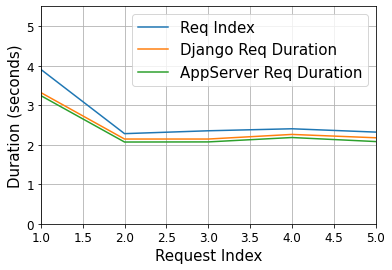

In [90]:
df = submit_serial_requests()
make_performance_plot(df)

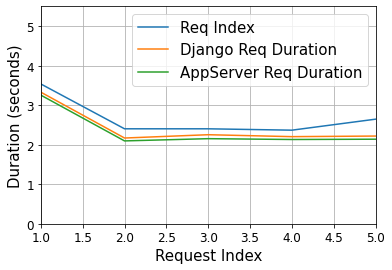

In [88]:
make_performance_plot(df)

### HTTP Post to application server directly

Here we make an HTTP Post to the application directly. Normally, it will not be possible to access the aplication server directly. I have included this test to identify latency problems and bottle necks between Django server and application server.

#### Sample parameters


In [24]:
# Set parameters for sample call to application server
# Need to derive some of the other data from the database
# TODO: Update the application code so we derive that data from the database
# TODO: Reduce data that is specified as part of the of input data
data = {
    "user-id": 1,
    "project-id": "084de6a9-03b8-4eb2-bbe6-3407eda32b20",
    "model-name": "xz-nz-model",
    "model-version": "v2.1.7",
    "model-directory": "apisds/production_models/v2.1.7/xz-nz-model/",
    "eval-host-ip": "localhost",
    "real-ids": [
        1
    ],    
    "max-num-real": 1,
    "delete": "NO",
    "server-port": 50100,
    "json-file-data": input_data,
}
data = json.dumps(data)

In [26]:
# view sample data
print(data)

{"user-id": 1, "project-id": "084de6a9-03b8-4eb2-bbe6-3407eda32b20", "model-name": "xz-nz-model", "model-version": "v2.1.7", "model-directory": "apisds/production_models/v2.1.7/xz-nz-model/", "eval-host-ip": "localhost", "real-ids": [1], "max-num-real": 1, "delete": "NO", "server-port": 50100, "json-file-data": "{\"projectid\": \"66333aca-b53a-4ced-bf41-9c06a75bc643\", \"delete\": \"NO\", \"field-results\": \"YES\", \"well-results\": \"YES\", \"results\": [\"npv\", \"cop\"], \"parameters\": [[{\"welltype\": 0, \"heel\": [1, 1, 1], \"toe\": [1, 1, 1]}, {\"welltype\": 1, \"heel\": [50, 1, 1], \"toe\": [50, 1, 1]}, {\"welltype\": 0, \"heel\": [100, 1, 1], \"toe\": [100, 1, 1]}]]}"}


#### Call the application server (and make plot of results if successful)

Success: Remote simulation job executed
[{'real_id': 1, 'status': 'SUCCESS', 'case': 'case-04f6016ead4f673', 'job_start_time': '2021926 15:50:47.793553 GMT-05:00', 'job_end_time': '2021926 15:50:51.28081  GMT-05:00', 'duration': 3.234561, 'job_directory': '/tmp/simulations/case-04f6016ead4f673', 'deleted': 'NO', 'cum_oil': 602367.16, 'npv': 7409165.5, 'well_names': ['PROD-1', 'PROD-2', 'INJE-1'], 'producer_well_names': ['PROD-1', 'PROD-2'], 'injector_well_names': ['INJE-1'], 'well_results': {'PROD-1': {'unit-system': 'FIELD', 'time-days': [0.0, 1.0, 2.978797, 7.303366, 13.25132, 18.45103, 24.72551, 31.0, 39.3457, 49.17996, 54.58998, 60.0, 69.11114, 79.366416, 85.183215, 91.0, 100.9639, 110.981904, 121.0, 132.9226, 142.4613, 152.0, 165.1273, 173.5636, 182.0, 194.4752, 203.7376, 213.0, 226.49421, 235.2471, 244.0, 257.30398, 265.652, 274.0, 287.6128, 296.3064, 305.0, 319.72408, 335.0, 350.5, 366.0, 381.5, 397.0, 411.0, 425.0, 440.5, 456.0, 471.0, 486.0, 501.5, 517.0, 532.0, 547.0, 562.5, 

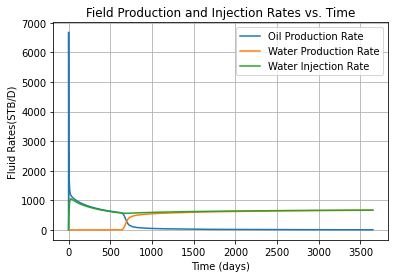

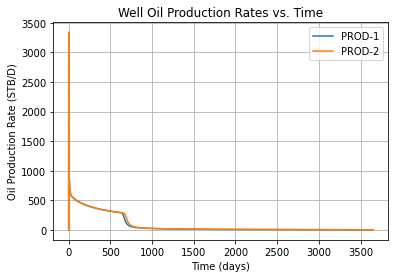

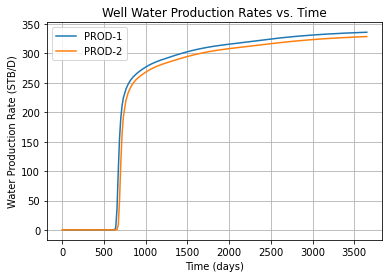

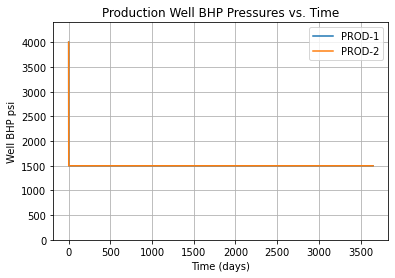

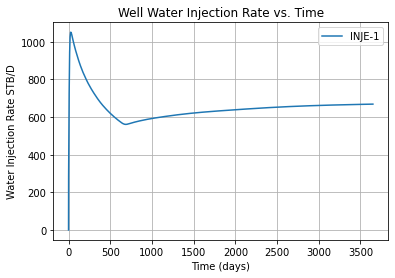

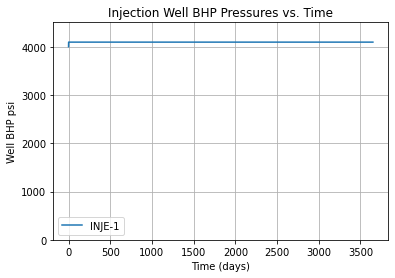

In [156]:
response = requests.post(APP_SERVER_API, data=data)
if response.status_code == 200:
    print('Success: Remote simulation job executed')
    response_json = response.json()
    print(response_json)
    # if the request is successful, we extract the results from the response 
    # and make some plots of the production profiles
    sim_results = response_json[0]
    make_plots(sim_results)    
else:
    print('Failed: Remote simulation job failed')


### Simulate multiple serial calls to remote servers 

Here we perform a simulation of perform several serial calls to the remote servers (Django and application). The goal of the tests is to test the performance of calls. 

It should be noted that this is a limited test as the Django and application servers are on the same Linux machine. 


We performed simulations with 500 calls to the Django and application servers respectively. The simulation tracks the HTTP response times for each of the 500 requests to both servers. The results are shown in the plot below. <img src="output/serial_remote_calls_500.png" width=800 height=800 />

In general, the response time for all the requests stays at around 2 seconds. For the case of calling Django server, there is not much latency between Django and application server. The spikes in the results can be attributed to the fact that the test Linux box was running other applications, so occasionally we see spikes in the response times. 

Please note that this is a limited test as HTTP requests origin from the same Linux machine hosting the Django and application servers. 




### Calling application running in a Docker container
For this test we built an Docker image of the application and then launch the container mapping a port from the container to the host machine. The request durations of performing 50 seriall requests are shown in the plot below.

<img src="output/serial_remote_calls_50_app_in_container.png" width=900 height=800 />

This computations inside the container are about 10 times that the native results (application launched in a shell). I will have to debug why the computations in the Docker container are much slower. 

### Future work: Test performance with servers hosted on cloud

Next, we will perform analyses with the servers deployed on the cloud to simulate real application usage and repeat these serial calls to the Django and application servers. Additionally, we will stress test the application to handle multiple synchronous calls to the application.

### Code for serial calls to Django and application server

### Perform runs by calling the application directly


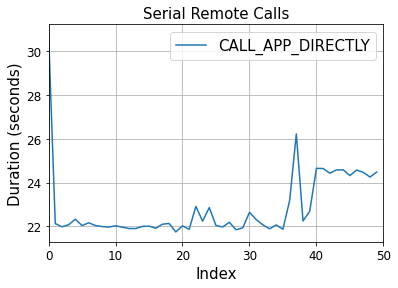

In [61]:
# Call the application server directly with num_calls specified above
df = run_app_serial_test()


In [62]:
df.to_csv('output/serial_remote_calls_50_app_in_docker_run2.csv', index=False)

In [54]:
#df = pd.read_csv('output/serial_remote_calls_50_app_in_docker.csv')